# Import

In [1]:
#Imports
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import io

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from PIL import Image
import base64
from base64 import decodestring
import json
import time


# Utilities used
from utils import visualization_utils as vis_util
from utils.dataflow import *

In [2]:
# load image into numpy array
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size

  try:
   image_np = np.array(image.getdata()).reshape(
      (im_height, im_width, 4)).astype(np.uint8)

  except:
   image_np = np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


  image_np=image_np[:,:,:3]
  #print(image_np.shape)
  return image_np

In [3]:
# Running inference on single image
def run_inference_for_single_image(image, graph):
  # Get handles to input and output tensors

  image_tensor = graph.get_tensor_by_name('image_tensor:0')
  # Run inference
  output_dict = sess.run(tensor_dict,
                          feed_dict={image_tensor: np.expand_dims(image, 0)})

  # all outputs are float32 numpy arrays, so convert types as appropriate
  output_dict['num_detections'] = int(output_dict['num_detections'][0])
  output_dict['detection_classes'] = output_dict[
      'detection_classes'][0].astype(np.uint8)
  output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
  output_dict['detection_scores'] = output_dict['detection_scores'][0]
  if 'detection_masks' in output_dict:
    output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [4]:
def get_scores_labels(output_dict,confidence_limit):
    result=[]
    labels=[]
    detection_classes=output_dict['detection_classes']
    detection_scores=output_dict['detection_scores']
    for i in range(detection_classes.shape[0]):
        if detection_scores[i]>confidence_limit:
            result.append([category_index[str(detection_classes[i])],detection_scores[i]*100])
            labels.append(category_index[str(detection_classes[i])])
    return result,labels

In [5]:
class InferenceServer():

    @staticmethod
    def push(data):

        print('Image received')
        confidence_limit=0.3


        image_data = base64.b64decode(data)
        image = Image.open(io.BytesIO(image_data))
        image.save('inf_images/Image_received.png')

        #Converting to numpy array
        image_np = load_image_into_numpy_array(image)

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        #image_np_expanded = np.expand_dims(image_np, axis=0)

        start_time=time.time()
        # Actual detection.
        output_dict = run_inference_for_single_image(image_np, detection_graph)
        end_time=time.time()
        time_taken=end_time-start_time
        print("Time Taken for Inference is:",time_taken)

        result,labels=get_scores_labels(output_dict,confidence_limit)

        if save_image:
            # The results of a detection is visualized
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=8)
            im = Image.fromarray(image_np)
            #im.save('inf_images/Inference.jpg')

            if len(labels)>0:
                name=labels[0]
                if name =='car' or name =='person':
                    im.save('inf_images/'+name+'.jpg')





        print("Result is:",result)

        return labels
        #except Exception as inst:

# Main function

In [6]:
config = tf.ConfigProto()

In [7]:
config.gpu_options.allow_growth = True

In [8]:
MODEL_NAME = 'ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03'

In [9]:
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

In [10]:
# Load a (frozen) Tensorflow model into memory.
	detection_graph = tf.Graph()
	with detection_graph.as_default():
	  od_graph_def = tf.GraphDef()
	  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
	    serialized_graph = fid.read()
	    od_graph_def.ParseFromString(serialized_graph)
	    tf.import_graph_def(od_graph_def, name='')

In [11]:
# Loading label map
	with open('data/labels.json') as f:
	    category_index = json.load(f)


In [12]:
# TensorFlow Session
sess=tf.Session(graph=detection_graph)


In [13]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}

In [14]:
#print(all_tensor_names)

In [15]:
tensor_dict = {}
for key in ['num_detections', 'detection_boxes', 'detection_scores','detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)

In [16]:
tensor_dict

{'detection_boxes': <tf.Tensor 'detection_boxes:0' shape=<unknown> dtype=float32>,
 'detection_classes': <tf.Tensor 'detection_classes:0' shape=<unknown> dtype=float32>,
 'detection_scores': <tf.Tensor 'detection_scores:0' shape=<unknown> dtype=float32>,
 'num_detections': <tf.Tensor 'num_detections:0' shape=<unknown> dtype=float32>}

In [17]:
filepath = 'inf_images/Image_received.png'

In [18]:
image = Image.open(filepath)

In [19]:
image_np = load_image_into_numpy_array(image)

In [20]:
image_np.shape

(144, 256, 3)

In [21]:
output_dict = run_inference_for_single_image(image_np, detection_graph)

In [22]:
#output_dict

In [23]:
confidence_limit = 0.3
result,labels=get_scores_labels(output_dict,confidence_limit)

In [24]:
result

[['car', 60.77483296394348],
 ['car', 60.281920433044434],
 ['car', 59.01527404785156],
 ['car', 55.158013105392456],
 ['car', 52.64632701873779],
 ['car', 52.40187048912048],
 ['car', 50.91890096664429],
 ['car', 49.840494990348816],
 ['car', 47.840720415115356],
 ['traffic light', 47.13200032711029],
 ['car', 46.18980586528778],
 ['car', 45.594990253448486],
 ['motorcycle', 41.86326265335083],
 ['car', 41.76898896694183],
 ['car', 41.34030640125275],
 ['truck', 39.55919146537781],
 ['car', 38.354578614234924],
 ['car', 37.09632456302643],
 ['car', 35.712459683418274],
 ['car', 35.56082546710968],
 ['car', 35.285684466362],
 ['suitcase', 34.68858301639557],
 ['car', 34.535643458366394],
 ['car', 33.80241394042969],
 ['car', 31.71650469303131],
 ['traffic light', 30.83450496196747],
 ['truck', 30.122482776641846]]

# Visualize the image bounding boxes

In [25]:
category_index

{'1': 'person',
 '10': 'traffic light',
 '11': 'fire hydrant',
 '13': 'stop sign',
 '14': 'parking meter',
 '15': 'bench',
 '16': 'bird',
 '17': 'cat',
 '18': 'dog',
 '19': 'horse',
 '2': 'bicycle',
 '20': 'sheep',
 '21': 'cow',
 '22': 'elephant',
 '23': 'bear',
 '24': 'zebra',
 '25': 'giraffe',
 '27': 'backpack',
 '28': 'umbrella',
 '3': 'car',
 '31': 'handbag',
 '32': 'tie',
 '33': 'suitcase',
 '34': 'frisbee',
 '35': 'skis',
 '36': 'snowboard',
 '37': 'sports ball',
 '38': 'kite',
 '39': 'baseball bat',
 '4': 'motorcycle',
 '40': 'baseball glove',
 '41': 'skateboard',
 '42': 'surfboard',
 '43': 'tennis racket',
 '44': 'bottle',
 '46': 'wine glass',
 '47': 'cup',
 '48': 'fork',
 '49': 'knife',
 '5': 'airplane',
 '50': 'spoon',
 '51': 'bowl',
 '52': 'banana',
 '53': 'apple',
 '54': 'sandwich',
 '55': 'orange',
 '56': 'broccoli',
 '57': 'carrot',
 '58': 'hot dog',
 '59': 'pizza',
 '6': 'bus',
 '60': 'donut',
 '61': 'cake',
 '62': 'chair',
 '63': 'couch',
 '64': 'potted plant',
 '65': '

In [26]:
res = vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=2)

In [27]:
from matplotlib import pyplot as plt

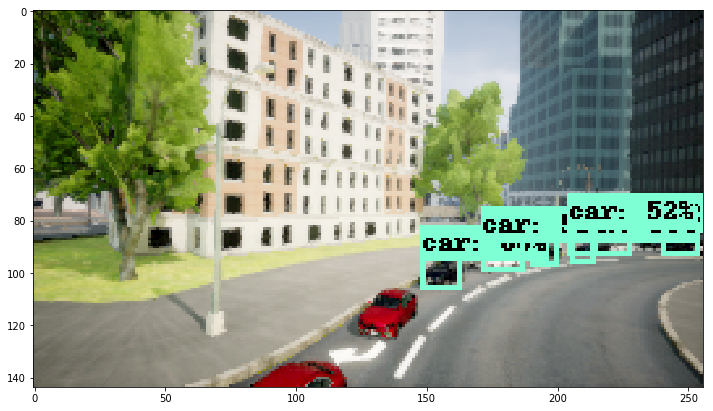

In [28]:
IMAGE_SIZE = (12, 8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)